In [1]:
## Distributed python packages
import os
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import datetime

from cartopy import crs as ccrs
from cartopy import feature as cfeature
from math import radians, log
## Own python package
from source_microseism import site_effect, open_bathy
__author__ = "Lisa Tomasetto"
__copyright__ = "Copyright 2024, UGA"
__credits__ = ["Lisa Tomasetto"]
__version__ = "1.0"
__maintainer__ = "Lisa Tomasetto"
__email__ = "lisa.tomasetto@univ-grenoble-alpes.fr"
__status__ = "Developpement"

# Spatial Extent

In [2]:
# extent
lat_min = -10 # -78 min
lat_max = 50 # 80 max
lon_min = 100 # -180 min
lon_max = 180 # 180 max

extent = [lon_min, lon_max, lat_min, lat_max]

# Open Bathymetry

- 0.5°x0.5° default bathymetry file.

 dpt1 shape  (3600, 4800)


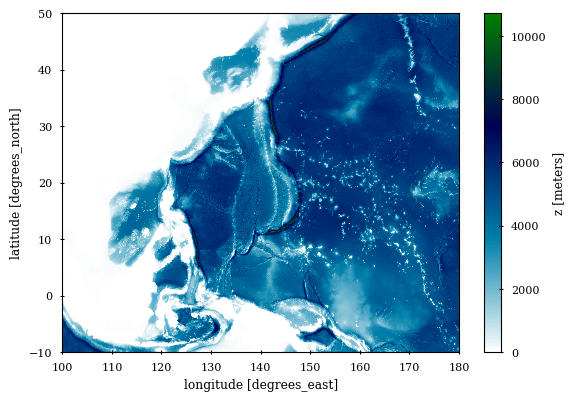

In [3]:
# bathymetry default
file_bathy = "./ww3.07121700.dpt"  #0.5x0.5 degree grid bathymetry
dpt1, zlon, zlat = open_bathy(file_bathy, refined_bathymetry=True, extent=extent)

# Plot
dpt1.plot(cmap='ocean_r')
plt.show()

# Amplification Coefficients 
We compute the amplitude response functions for the normal modes, from Longuet-Higgins (1950). $C(f, h) = \sum_{i=1}^{4} c_i(f,h)^2$.
Where h is the water column depth and f the seismic frequency.

For details on the computation see references:
- LONGUET-HIGGINS, Michael Selwyn. A theory of the origin of microseisms. Philosophical Transactions of the Royal Society of London. Series A, Mathematical and Physical Sciences, 1950, vol. 243, no 857, p. 1-35.https://doi-org.insu.bib.cnrs.fr/10.1098/rsta.1950.0012
- GIMBERT, Florent et TSAI, Victor C. Predicting short-period, wind-wave-generated seismic noise in coastal regions. Earth and Planetary Science Letters, 2015, vol. 426, p. 280-292. https://doi-org.insu.bib.cnrs.fr/10.1016/j.epsl.2015.06.017

In [5]:
# Amplification map
f = np.arange(0.1, 0.51, 0.05)
vs_crust = 2.8

print("THIS SHOULD TAKE 5 MINUTES TO RUN")
path = './longuet_higgins.txt'
amplif = site_effect(dpt1, f, vs_crust, path, zlat, zlon)

THIS SHOULD TAKE 5 MINUTES TO RUN


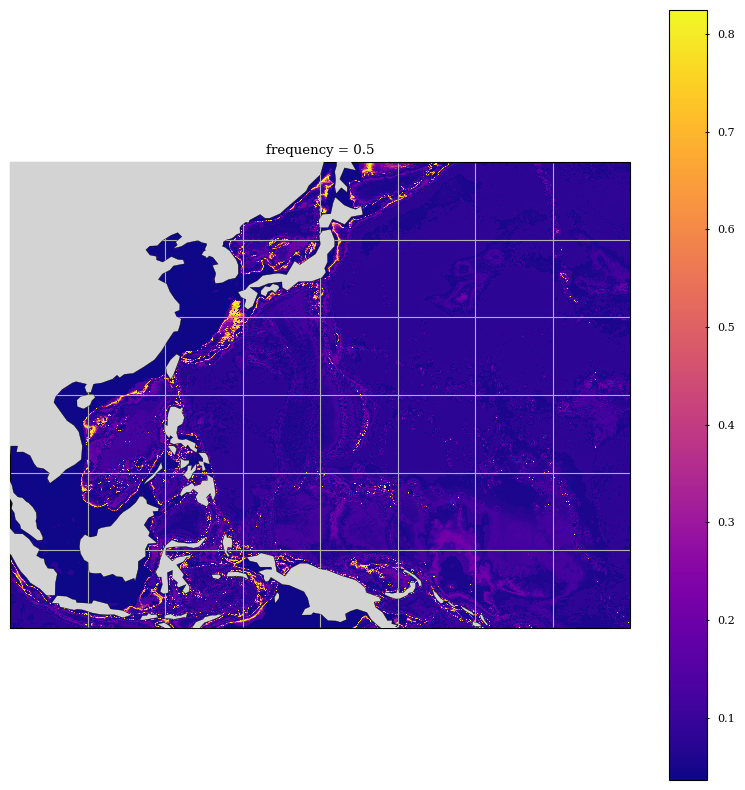

In [6]:
# Plot 
amplif_plot = amplif.sel(frequency= 0.5, method='nearest')
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_title("Amplification coefficient")
ax.coastlines()
ax.gridlines()
ax.add_feature(cfeature.LAND, zorder=100, edgecolor='k', facecolor='lightgrey')
amplif_plot.plot(cmap='plasma', transform=ccrs.PlateCarree(), ax=ax)
plt.show()